# Logisitic Regression and Support Vector Machines Minilab

You are to perform predictive analysis (classification) upon a data set: model the dataset using methods we have discussed in class: logistic regression and support vector machines, and making conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 10% of the final grade. You may complete this assignment in teams of as many as three people.  




By Martin Garcia, Joanna Duran, Daniel Byrne

## Packages

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import time

from sklearn.linear_model import SGDClassifier
from sklearn import svm

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Business Understanding

Our objective is to create a logistic regression model and a support vector machine model for the classification of each image. We will determine which is a better model based on prediction accuracy, training time, and efficiency.The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6,000 images per class. 

Our objective is to create a logistic regression model and a support vector machine model for the classification of each image in our test set. We will determine which model is best suited for this standard classification task based on a comparison on their prediction accuracy, training times, and computational efficiency.

## Data Meaning Type

### The CIFAR-10 dataset

We are using the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The dataset includes are 50000(80%) training images and 10000(20%) test images broken in to 5 pre-randomized training batches and 1 test batch.

Each training batch contains 10,000 observations with a row vector of length 3072 representative of color image of 32x32 pixels. The first 1024 columns consist of red values, followed by green, and blue. The data also incorporates labels ranging from 0 to 9 and are listed below.

* airplane : 0
* automobile : 1
* bird : 2
* cat : 3
* deer : 4
* dog : 5
* frog : 6
* horse : 7
* ship : 8
* truck : 9

The test batch contains 1000 randomly-selected images from each class. The 5 training batches are randomized and contain a variable number of images from each class. 

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

## Simple Statistics

In [2]:
#load the data, reshape to 32x32 matrix per color, transpose matrices
def load_cfar10_batch(path, batch_id = None, reshape = True):
    """
    Argument:
    path -- path the datasets
    batch_id -- id of the batch (1 to 5) to load
    
    Returns:
    parameters -- python dictionary containing:
                    X -- features
                    Y -- labels
    """
    if batch_id is not None:
        filepath = path + 'data_batch_' + str(batch_id)
    else:
        filepath = path
        
    with open(filepath, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
    
    if reshape:    
        X = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        Y = np.array(batch['labels'])
    else:
        X = batch['data']
        Y = np.array(batch['labels'])
        
    return X, Y


Stats of batch #4:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 1003
Label Counts of [1](AUTOMOBILE) : 963
Label Counts of [2](BIRD) : 1041
Label Counts of [3](CAT) : 976
Label Counts of [4](DEER) : 1004
Label Counts of [5](DOG) : 1021
Label Counts of [6](FROG) : 1004
Label Counts of [7](HORSE) : 981
Label Counts of [8](SHIP) : 1024
Label Counts of [9](TRUCK) : 983

Example of Image 5926:
Image - Min Value: 1 Max Value: 223
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


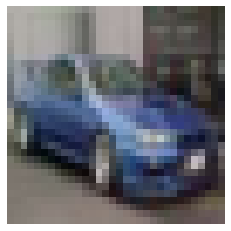

In [3]:
#load labels for our label
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#display images
def display_stats(data, batch_id, sample_id):
    features, labels = load_cfar10_batch(data, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

batch_id = random.randint(1,5)
sample_id = random.randint(1,10000)
display_stats( "data/", batch_id, sample_id)

## Models

In this section we will create a logistic regression model and a support vector machine model for the classification task involved with your dataset.  We will assess how well each model performs (use 80/20 training/testing split)and adjust parameters of the models to make them more accurate. 

### Logistic Regression Model

In [30]:
# Build Logistic Regression Model with Stochastic Gradient Descent 
X,Y = load_cfar10_batch("data/",1,False)

for n in range(2,6):
    x,y = load_cfar10_batch("data/",n,False)    
    X = np.concatenate((X,x),axis=0)
    Y = np.concatenate((Y,y),axis=0)

test_X,test_Y = load_cfar10_batch("data/test_batch",None,False)

# Modify the dataset labels to lable cats/not/cats
#(if_test_is_false, if_test_is_true)[test]
catY = (Y == 3)
cat_test_Y = (test_Y == 3) 

sgdlr = SGDClassifier(alpha=0.001, max_iter=5000, tol=1e-3,verbose=1,n_jobs=4,loss="log")

print("Data shape: ",X.shape)
print("Labels shape: ",catY.shape)

print("Test Data shape: ",test_X.shape)
print("Test Labels shape: ",cat_test_Y.shape)



Data shape:  (50000, 3072)
Labels shape:  (50000,)
Test Data shape:  (10000, 3072)
Test Labels shape:  (10000,)


In [ ]:
import time

start = time.time()
sgdlr.fit(X,catY)
end = time.time()
elapsed = end - start
print("Training complete.  Time elapsed = ",elapsed)
score = sgdlr.score(test_X,cat_test_Y)
print(score)

-- Epoch 1
Norm: 1962.41, NNZs: 3072, Bias: -9.919591, T: 50000, Avg. loss: 497197.367873
Total training time: 0.39 seconds.
-- Epoch 2
Norm: 1291.19, NNZs: 3072, Bias: -10.536351, T: 100000, Avg. loss: 61990.560425
Total training time: 0.81 seconds.
-- Epoch 3
Norm: 980.01, NNZs: 3072, Bias: -11.172319, T: 150000, Avg. loss: 35871.019564
Total training time: 1.20 seconds.
-- Epoch 4
Norm: 861.69, NNZs: 3072, Bias: -11.589602, T: 200000, Avg. loss: 25937.702453
Total training time: 1.61 seconds.
-- Epoch 5
Norm: 755.60, NNZs: 3072, Bias: -11.944231, T: 250000, Avg. loss: 20101.343957
Total training time: 1.96 seconds.
-- Epoch 6
Norm: 689.83, NNZs: 3072, Bias: -12.127458, T: 300000, Avg. loss: 16114.389292
Total training time: 2.43 seconds.
-- Epoch 7
Norm: 631.93, NNZs: 3072, Bias: -12.249748, T: 350000, Avg. loss: 13714.221395
Total training time: 2.83 seconds.
-- Epoch 8


### Support Vector Machine Model

In [ ]:
# Build SVM Regression Model with Stochastic Gradient Descent 
sgd_svm = SGDClassifier(alpha=0.001, max_iter=5000, verbose = 1, tol=1e-3,n_jobs=4)

In [ ]:
sgd_svm.fit(X,catY)

In [ ]:
svmscore = sgd_svm.score(test_X,cat_test_Y)
print(svmscore)

### Model Advantages

In this section we will discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

### Interpreting Feature Importance

In this section we will use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

### Interpreting Support Vectors

In this section we will look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.